In [18]:
# Imports

import cv2
import numpy as np 
from scipy.interpolate import interp1d
from pyefd import elliptic_fourier_descriptors
from matplotlib import pyplot as plt
import pathlib


%matplotlib inline

In [8]:
def process_image_and_calculate_dft(image_path, target_length=256):

    # Load image
    img = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5, 5), 0)

    _, thresh = cv2.threshold(blur, 1, 255, cv2.THRESH_BINARY)

    # plt.imshow(gray)
    # plt.show()

    # plt.imshow(thresh)
    # plt.show()

    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    if not contours:
        raise ValueError("No contours found")
    
    coeffs = []

    for cnt in contours:
        # Find the coefficients of the contours
        coeffs.append(elliptic_fourier_descriptors(np.squeeze(cnt, axis=1), order=10))

    potato_contour = max(contours, key=cv2.contourArea)

    M = cv2.moments(potato_contour)

    if M['m00'] == 0:
        raise ValueError("Invalid contour")
    
    # Calculate the centroid
    cx = int(M['m10']/M['m00'])
    cy = int(M['m01']/M['m00'])

    potato_contour = potato_contour.squeeze()

    distances = np.sqrt((potato_contour[:, 0] - cx)**2 + (potato_contour[:, 1] - cy)**2)

    x_old = np.linspace(0, 1, len(distances))
    f = interp1d(x_old, distances, kind='linear')
    x_new = np.linspace(0, 1, target_length)

    distances_interpolated = f(x_new)

    # Normalize the interpolated distances so that the maximum distance is 250
    max_distance = np.max(distances_interpolated)
    distances_normalized = distances_interpolated / max_distance * 250

    dft_result = np.fft.fft(distances_normalized)

    dft_magnitude = np.abs(dft_result)    

    return dft_magnitude

In [9]:
# Plotting the DFT and Images
def show_images_and_dft(img_path, check):
    img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
    plt.figsize = (12, 6)
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title('Original Image')

    plt.subplot(1, 2, 2)
    plt.plot(check[:256 // 2])  # Plot only half (symmetrical)
    # plt.plot(check[:256])  
    plt.title('Fourier Magnitude')
    plt.xlabel('Frequency')
    plt.ylabel('Magnitude')

    plt.tight_layout()
    plt.show()

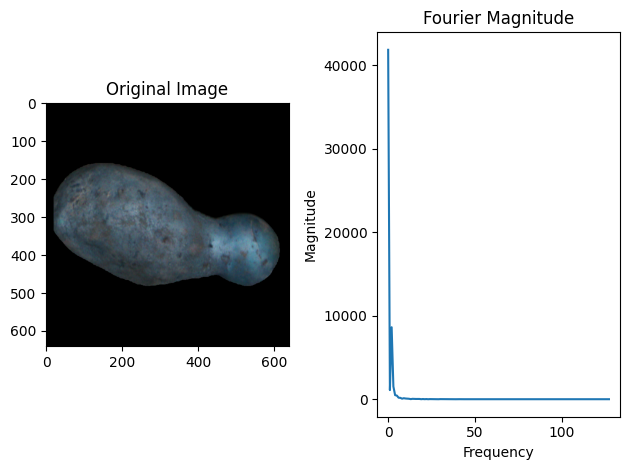

In [10]:
img_path = "/home/mishkat/Downloads/malformed_potato/potato_good_malformed/malformed_potatoes_fourier_2_class/malformed/sd_malformed_12_2_1_114_9.png"
check = process_image_and_calculate_dft(img_path)
show_images_and_dft(img_path, check)

In [49]:
energy_ratio_all = []
peak_frequency_all = []
spectral_entropy_all = []

In [12]:
# Test MS C
# def analyze_shape(dft_magnitude):
#     # Calculate the energy ratio
#     total_energy = np.sum(dft_magnitude)
#     energy_ratio_all.append(dft_magnitude[0] / total_energy)

#     # Find the peak frequency
#     peak_frequency_all.append(np.argmax(dft_magnitude))

#     return energy_ratio, peak_frequency

In [47]:
# Test Google G
def analyze_shape_for_print(dft_magnitude):
    energy_ratio = np.sum(dft_magnitude[:10] / np.sum(dft_magnitude))
    peak_frequency = np.argmax(dft_magnitude)

    print(f"Energy Ratio: {energy_ratio:.2f}")
    print(f"Peak Frequency: {peak_frequency}")


In [50]:
def analyze_shape_for_good_potato(dft_magnitude):
    energy_ratio = np.sum(dft_magnitude[:10] / np.sum(dft_magnitude))
    peak_frequency = np.argmax(dft_magnitude)
    # Calculate the spectral entropy
    probabilities = dft_magnitude / np.sum(dft_magnitude)
    spectral_entropy = -np.sum(probabilities * np.log2(probabilities + 1e-10))
    
    spectral_entropy_all.append(spectral_entropy)
    energy_ratio_all.append(energy_ratio)
    peak_frequency_all.append(peak_frequency)
    

In [20]:
import time

In [51]:
energy_ratio_all.clear()
peak_frequency_all.clear()

In [52]:
# Running on Good Potatoes Images

# start time
start = time.time()

for img in pathlib.Path('/home/mishkat/Downloads/malformed_potato/potato_good_malformed/malformed_potatoes_fourier_2_class/good').iterdir():
    img_path = str(img)
    check = process_image_and_calculate_dft(img_path)
    analyze_shape_for_good_potato(check)

# end time
end = time.time()
# total time taken
print(f"Runtime of the program is {end - start}")

Runtime of the program is 1.046678066253662


In [53]:
print(f"Number of images: {len(energy_ratio_all)}")
print(f"Max Energy Ratio: {max(energy_ratio_all):.2f}")
print(f"Min Energy Ratio: {min(energy_ratio_all):.2f}")
print(f"Average Energy Ratio: {np.mean(energy_ratio_all):.2f}")
print(f"Median Energy Ratio: {np.median(energy_ratio_all):.2f}")
print(f"Max Peak Frequency: {max(peak_frequency_all)}")
print(f"Min Peak Frequency: {min(peak_frequency_all)}")
print(f"Average Peak Frequency: {np.mean(peak_frequency_all):.2f}")
print(f"Median Peak Frequency: {np.median(peak_frequency_all)}")
print(f"Max Spectral Entropy: {max(spectral_entropy_all):.2f}")
print(f"Min Spectral Entropy: {min(spectral_entropy_all):.2f}")
print(f"Average Spectral Entropy: {np.mean(spectral_entropy_all):.2f}")
print(f"Median Spectral Entropy: {np.median(spectral_entropy_all):.2f}")

Number of images: 119
Max Energy Ratio: 0.90
Min Energy Ratio: 0.79
Average Energy Ratio: 0.86
Median Energy Ratio: 0.87
Max Peak Frequency: 0
Min Peak Frequency: 0
Average Peak Frequency: 0.00
Median Peak Frequency: 0.0
Max Spectral Entropy: 2.53
Min Spectral Entropy: 1.36
Average Spectral Entropy: 1.79
Median Spectral Entropy: 1.76


In [54]:
energy_ratio_all.clear()
peak_frequency_all.clear()
spectral_entropy_all.clear()

In [55]:
# Running on Good Bottleneck Images

# start time
start = time.time()

for img in pathlib.Path('/home/mishkat/Downloads/malformed_potato/potato_good_malformed/malformed_potatoes_fourier_3_class/bottleneck').iterdir():
    img_path = str(img)
    check = process_image_and_calculate_dft(img_path)
    analyze_shape_for_good_potato(check)

# end time
end = time.time()
# total time taken
print(f"Runtime of the program is {end - start}")

Runtime of the program is 0.6750690937042236


In [56]:
print(f"Number of images: {len(energy_ratio_all)}")
print(f"Max Energy Ratio: {max(energy_ratio_all):.2f}")
print(f"Min Energy Ratio: {min(energy_ratio_all):.2f}")
print(f"Average Energy Ratio: {np.mean(energy_ratio_all):.2f}")
print(f"Median Energy Ratio: {np.median(energy_ratio_all):.2f}")
print(f"Max Peak Frequency: {max(peak_frequency_all)}")
print(f"Min Peak Frequency: {min(peak_frequency_all)}")
print(f"Average Peak Frequency: {np.mean(peak_frequency_all):.2f}")
print(f"Median Peak Frequency: {np.median(peak_frequency_all)}")
print(f"Max Spectral Entropy: {max(spectral_entropy_all):.2f}")
print(f"Min Spectral Entropy: {min(spectral_entropy_all):.2f}")
print(f"Average Spectral Entropy: {np.mean(spectral_entropy_all):.2f}")
print(f"Median Spectral Entropy: {np.median(spectral_entropy_all):.2f}")

Number of images: 59
Max Energy Ratio: 0.81
Min Energy Ratio: 0.74
Average Energy Ratio: 0.78
Median Energy Ratio: 0.77
Max Peak Frequency: 0
Min Peak Frequency: 0
Average Peak Frequency: 0.00
Median Peak Frequency: 0.0
Max Spectral Entropy: 2.88
Min Spectral Entropy: 2.22
Average Spectral Entropy: 2.49
Median Spectral Entropy: 2.49


In [57]:
energy_ratio_all.clear()
peak_frequency_all.clear()
spectral_entropy_all.clear()

In [58]:
# Running on Good Ugly Images

# start time
start = time.time()

for img in pathlib.Path('/home/mishkat/Downloads/malformed_potato/potato_good_malformed/malformed_potatoes_fourier_3_class/ugly').iterdir():
    img_path = str(img)
    check = process_image_and_calculate_dft(img_path)
    analyze_shape_for_good_potato(check)

# end time
end = time.time()
# total time taken
print(f"Runtime of the program is {end - start}")

Runtime of the program is 0.5459098815917969


In [59]:
print(f"Number of images: {len(energy_ratio_all)}")
print(f"Max Energy Ratio: {max(energy_ratio_all):.2f}")
print(f"Min Energy Ratio: {min(energy_ratio_all):.2f}")
print(f"Average Energy Ratio: {np.mean(energy_ratio_all):.2f}")
print(f"Median Energy Ratio: {np.median(energy_ratio_all):.2f}")
print(f"Max Peak Frequency: {max(peak_frequency_all)}")
print(f"Min Peak Frequency: {min(peak_frequency_all)}")
print(f"Average Peak Frequency: {np.mean(peak_frequency_all):.2f}")
print(f"Median Peak Frequency: {np.median(peak_frequency_all)}")
print(f"Max Spectral Entropy: {max(spectral_entropy_all):.2f}")
print(f"Min Spectral Entropy: {min(spectral_entropy_all):.2f}")
print(f"Average Spectral Entropy: {np.mean(spectral_entropy_all):.2f}")
print(f"Median Spectral Entropy: {np.median(spectral_entropy_all):.2f}")

Number of images: 67
Max Energy Ratio: 0.85
Min Energy Ratio: 0.75
Average Energy Ratio: 0.81
Median Energy Ratio: 0.82
Max Peak Frequency: 0
Min Peak Frequency: 0
Average Peak Frequency: 0.00
Median Peak Frequency: 0.0
Max Spectral Entropy: 2.94
Min Spectral Entropy: 1.85
Average Spectral Entropy: 2.28
Median Spectral Entropy: 2.23
